# **GEDI L2A and L4A Subsetting**
This notebook provides a tutorial on how to subset GEDI data on the NASA MAAP. To run this notebook a MAAP account is needed. Please contact Laura Duncanson (lduncans@umd.edu) to discuss requesting an account or requesting national subsetting to replicate this tutorial for another country or region. This example shows subsetting over Ghana, but this exact same code was run to subset data over 15 West African countries. This subset L2A data (which includes GEDI height data, RH98) and is used in the final notebook to produce revised estimates of GEDI biomass.

### In this tutorial, we use the MAAP’s GEDI Subsetter to create spatial subsets of GEDI L2A and L4A data for a given area of interest (AOI). (Source: https://docs.maap-project.org/en/latest/science/GEDI/GEDI_L4A.html). 
These tools were developed by the NASA MAAP team, see links above. 

**Notebook authors:** 
Veronika Leitold, University of Maryland
Neha Hunka, University of Maryland


## **About the Data**

### GEDI L2A Elevation and Height Metrics Data Global Footprint Level

> This dataset provides Global Ecosystem Dynamics Investigation (GEDI) Level 2A (L2A) data, which has the purpose of providing waveform interpretation and extracted products from the GEDI L1B waveforms. These products include ground elevation, canopy top height, and relative height (RH) metrics. GEDI is attached to the International Space Station (ISS) and collects data globally between 51.6° N and 51.6° S latitudes at the highest resolution and densest sampling of any light detection and ranging (lidar) instrument in orbit to date; specifically, GEDI L2A data has a spatial resolution of 25m. (Source: https://lpdaac.usgs.gov/products/gedi02_av002/)


### GEDI L4A Footprint Level Aboveground Biomass Density, Version 2

> This dataset provides Global Ecosystem Dynamics Investigation (GEDI) Level 4 (L4) data, which has the purpose of providing mean aboveground biomass density (AGBD) and consists of the GEDI_L4A and GEDI_L4B collections. GEDI L4A contains predictions of AGBD and estimates of the prediction standard error. GEDI is attached to the International Space Station (ISS) and collects data globally between 51.6° N and 51.6° S latitudes at the highest resolution and densest sampling of any light detection and ranging (lidar) instrument in orbit to date; specifically, GEDI L4A data has a spatial resolution of 25m. (Source: https://daac.ornl.gov/GEDI/guides/GEDI_L4A_AGB_Density_V2_1.html)


## **Install Python Packages**

In [1]:
# Uncomment the following lines to install these packages if you haven't already.
!pip install geopandas
!pip install contextily
!pip install backoff
!pip install folium
!pip install geojsoncontour

In [2]:
#Import numpy for making column inputs easier
import numpy as np
import pandas as pd
import geopandas as gpd
import backoff
import shapely
import glob
import os

## **Obtain Username**
Every MAAP user has a username assigned when they join MAAP. This username determines where datasets are stored. In this example Veronika Leitold ran the subsetting code, so data were output to her directory.

In [3]:
from maap.maap import MAAP
maap = MAAP(maap_host="api.maap-project.org")
username = maap.profile.account_info()["username"]
username

'leitoldv'

## **Define the Area of Interest**

> You may use either a publicly available GeoJSON file for your AOI, such as those available at geoBoundaries, or you may create a custom GeoJSON file for your AOI. The following 2 subsections cover both cases.


### Using a geoBoundary GeoJSON File

> If your AOI is a publicly available geoBoundary, you can obtain the URL for the GeoJSON file using the function below. You simply need to supply an ISO3 value and a level. To find the appropriate ISO3 and level values, see the table on the geoBoundaries site (https://www.geoboundaries.org/).


In [4]:
import requests

def get_geo_boundary_url(iso3: str, level: int) -> str:
    response = requests.get(
        f"https://www.geoboundaries.org/api/current/gbOpen/{iso3}/ADM{level}"
    )
    response.raise_for_status()
    return response.json()["gjDownloadURL"]

# If using a geoBoundary, uncomment the following assignment, supply
# appropriate values for `<iso3>` and `<level>`, then run this cell.

# Example (Gabon level 0): get_geo_boundary("GAB", 0)
# aoi = get_geo_boundary_url("<iso3>", <level>)

### Using a Custom GeoJSON or GeoPackage File

> Alternatively, you can make your own GeoJSON file for your AOI and place it within your my-public-bucket folder within the ADE.

> Based upon where you place your GeoJSON file under my-public-bucket, you can construct the URL for a job’s aoi input value.

> For example, if the relative path of your AOI GeoJSON file under my-public-bucket is path/to/my-aoi.geojson (avoid using whitespace in the path and filename), the URL you would supply as the value of a job’s aoi input would be the following (where {username} is replaced with your username as output from the previous section): "https://maap-ops-workspace.s3.amazonaws.com/shared/{username}/path/to/my-aoi.geojson"

> If this is the case, use the line below:

> #aoi = f"https://maap-ops-workspace.s3.amazonaws.com/shared/{username}/langtang_np.geojson"

### Here we use **Ghana** as the example AOI (iso3 country code for Ghana is "GHA")

In [5]:
## aoi_path: "/FAO_WestAfrica/AOIs/GHA.geojson"
aoi = f"https://maap-ops-workspace.s3.amazonaws.com/shared/leitoldv/FAO_WestAfrica/AOIs/GHA.geojson"

## [OPTIONAL] **Visually Verify your AOI**

#### If you want to visually verify your AOI before proceeding, you may run the following cell, if you have the geopandas and contextily Python packages installed.

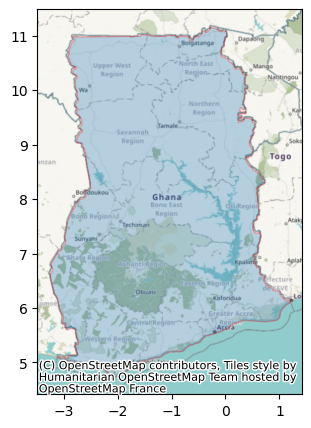

In [6]:
try:
    import geopandas as gpd
    import contextily as ctx
except:
    print(
        "If you wish to visually verify your AOI, "
        "you must install the `geopandas` and `contextily` packages."
    )
else:
    aoi_gdf = gpd.read_file(aoi)
    aoi_epsg4326 = aoi_gdf.to_crs(epsg=4326)
    ax = aoi_epsg4326.plot(figsize=(10, 5), alpha=0.3, edgecolor="red")
    ctx.add_basemap(ax, crs=4326)

## **Submit a Subsetting Job**

#### When supplying input values for a GEDI subsetting job, to use the default value for a field (where indicated), use a dash ("-") as the input value.

> **aoi** (required): URL to a GeoJSON file representing your area of interest, as explained above.

> **doi**: Digital Object Identifier (DOI) of the GEDI collection to subset, or a logical name representing such a DOI. Valid logical names: L1B, L2A, L2B, L4A

> **columns**: Comma-separated list of column names to include in the output file, see details below.

> **query**: Query expression for subsetting the rows in the output file.

> **limit**: Maximum number of GEDI granule data files to download (among those that intersect the specified AOI). (Default: 10000)

## For GEDI L2A Subsetting, we select the following variables for the "columns" argument:

> shot_number

> lat_lowestmode, lon_lowestmode

> rh10, rh20, rh30, rh40, rh50, rh60, rh70, rh80, rh90, rh98

> land_cover_data/pft_class

> geolocation/sensitivity_a2
        
#### **For the complete list of GEDI L2A variables see:** _https://lpdaac.usgs.gov/documents/982/gedi_l2a_dictionary_P003_v2.html_


## For GEDI L4A Subsetting, we select the following variables for the "columns" argument:

> shot_number

> lat_lowestmode, lon_lowestmode, elev_lowestmode

> agbd, agbd_se

> agbd_t, agbd_t_se

> sensitivity

#### **For the complete list of GEDI L4A variables see:** _https://daac.ornl.gov/GEDI/guides/GEDI_L4A_AGB_Density.html_

In [17]:
## Change "PRODUCTS" to L2A or L4A depending on which GEDI product you want to subset

PRODUCTS = ["L2A"] 
#PRODUCTS = ["L4A"]

if "L2A" in PRODUCTS:
        
    aoi_name = os.path.basename(aoi).split('.')[0]
    print(f"Thanks, I'll run the GEDI L2A subsetter for {aoi_name}!!")
        
    inputs = dict(
        aoi=aoi,
        doi="L2A",
        lat="lat_lowestmode",
        lon="lon_lowestmode",
        beams="all",
        columns="shot_number,lon_lowestmode,lat_lowestmode,rh10,rh20,rh30,rh40,rh50,rh60,rh70,rh80,rh90,rh98,land_cover_data/pft_class,geolocation/sensitivity_a2",
        query="quality_flag == 1",
        limit = 75_000,
        #temporal="-",
        output=f"{os.path.basename(aoi).split('.')[0]}_L2A.gpkg"
        )
    
    result = maap.submitJob(
        identifier="gedi-subset",
        algo_id="gedi-subset",
        version="0.9.0",
        queue="maap-dps-worker-64gb",
        username=username,
        **inputs
    )

if "L4A" in PRODUCTS:

    aoi_name = os.path.basename(aoi).split('.')[0]
    print(f"Thanks, I'll run the GEDI L4A subsetter for {aoi_name}!!")
    
    inputs = dict(
        aoi=aoi,
        doi="L4A",
        lat="lat_lowestmode",
        lon="lon_lowestmode",
        beams="all",
        columns="shot_number,lat_lowestmode,lon_lowestmode,elev_lowestmode,agbd,agbd_se,agbd_t,agbd_t_se,sensitivity,geolocation/sensitivity_a2",
        query="l2_quality_flag == 1 and l4_quality_flag == 1",# and sensitivity > 0.9", #  and geolocation/sensitivity_a2 > 0.95",
        limit = 75_000,
        #temporal="-",
        output=f"{os.path.basename(aoi).split('.')[0]}_L4A.gpkg"
    )
    
    result = maap.submitJob(
        identifier="gedi-subset",
        algo_id="gedi-subset",
        version="0.9.0",
        queue="maap-dps-worker-64gb",
        username=username,
        **inputs
    )

job_id = result.id
job_id or result


Thanks, I'll run the GEDI L2A subsetter for GHA!!


'fb366912-b04a-4f35-ad4d-bce419323357'

## **Get the Job’s Output File**

#### Now that the job has been submitted, we can use the job_id to check the job status until the job has been completed.

In [18]:
from urllib.parse import urlparse


def job_status_for(job_id: str) -> str:
    return maap.getJobStatus(job_id)


def job_result_for(job_id: str) -> str:
    return maap.getJobResult(job_id)[0]


def to_job_output_dir(job_result_url: str) -> str:
    return f"/projects/my-private-bucket/{job_result_url.split(f'/{username}/')[1]}"

#### If you have installed the backoff Python package, running the following cell will automatically repeatedly check your job’s status until the job has been completed. Otherwise, you will have to manually repeatedly rerun the following cell until the output is either 'Succeeded' or 'Failed'.

In [22]:
try:
    import backoff
except:
    job_status = job_status_for(job_id)
else:
    # Check job status every 2 minutes
    @backoff.on_predicate(
        backoff.constant,
        lambda status: status not in ["Deleted", "Succeeded", "Failed"],
        interval=120,
    )
    def wait_for_job(job_id: str) -> str:
        return job_status_for(job_id)

    job_status = wait_for_job(job_id)

job_status


'Succeeded'

In [25]:
assert job_status == "Succeeded", (
    job_result_for(job_id)
    if job_status == "Failed"
    else f"Job {job_id} has not yet completed ({job_status}). Rerun the prior cell."
)

output_url = job_result_for(job_id)
output_dir = to_job_output_dir(output_url)
output_file = f"{output_dir}/{os.path.basename(aoi).split('.')[0]}_L2A.gpkg"
#output_file = f"{output_dir}/{os.path.basename(aoi).split('.')[0]}_L4A.gpkg"
print(f"Your subset results are in the file {output_file}")

Your subset results are in the file /projects/my-private-bucket/dps_output/gedi-subset/0.9.0/gedi-subset/2025/04/10/20/39/17/353148/GHA_L2A.gpkg


## [OPTIONAL] **Visually Verify the Results**

#### If you installed the geopandas Python package, you can visually verify the output file by running the following cell.

                                            filename  \
0  GEDI02_A_2019145020819_O02535_03_T03384_02_003...   
1  GEDI02_A_2019145020819_O02535_03_T03384_02_003...   
2  GEDI02_A_2019145020819_O02535_03_T03384_02_003...   
3  GEDI02_A_2019145020819_O02535_03_T03384_02_003...   
4  GEDI02_A_2019145020819_O02535_03_T03384_02_003...   

   geolocation/sensitivity_a2  lon_lowestmode  rh60  rh50  rh10  rh70  rh80  \
0                    0.900199       -1.472551  0.29  0.00 -1.46  0.63  0.97   
1                    0.903937       -1.474658  2.39  1.34 -1.01  4.15  5.09   
2                    0.907181       -1.477070  0.56  0.18 -1.61  1.01  1.46   
3                    0.867118       -0.833503 -0.03 -0.33 -2.20  0.22  0.48   
4                    0.916258       -1.214043  6.92  5.99  0.00  7.97  9.13   

    rh90   rh98  rh30  rh20  lat_lowestmode  land_cover_data/pft_class  \
0   1.49   2.17 -0.59 -0.93        7.605792                          4   
1   5.99   6.81  0.14 -0.37        7.608

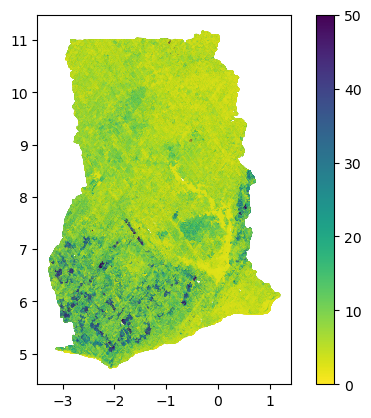

In [29]:
try:
    import geopandas as gpd
    import matplotlib.pyplot as plt
    import matplotlib
except:
    print(
        "If you wish to visually verify your output file, "
        "you must install the `geopandas` package."
    )
else:
    gedi_gdf = gpd.read_file(output_file)
    print(gedi_gdf.head())
    #sensitivity_colors = plt.cm.get_cmap("viridis_r")
    sensitivity_colors = matplotlib.colormaps["viridis_r"]
    gedi_gdf.plot(column="rh98", cmap="viridis_r", markersize=0.01, legend=True,
                  vmin=0,  # set your desired lower limit
                  vmax=50)   # set your desired upper limit


## [OPTIONAL] Copy .gpkg Output Files to User-defined Directory

In [32]:
import shutil
import os

output_url = job_result_for(job_id)
output_dir = to_job_output_dir(output_url)

# Define the suffix for the output file (change as needed)
output_suffix = "_L2A"  # or "_L4A", "_L2B", etc.

# Build the filename with the suffix
output_file = f"{output_dir}/{os.path.basename(aoi).split('.')[0]}{output_suffix}.gpkg"
print(f"Your subset results are in the file {output_file}")

# Define your target directory (e.g., target_dir = "/path/to/your/target/directory")
target_dir = "/projects/my-public-bucket/FAO_WestAfrica/DATA/"
os.makedirs(target_dir, exist_ok=True)

# Copy the file
shutil.copy(output_file, target_dir)
print(f"Copied output file to {target_dir}")


Your subset results are in the file /projects/my-private-bucket/dps_output/gedi-subset/0.9.0/gedi-subset/2025/04/10/20/39/17/353148/GHA_L2A.gpkg
Copied output file to /projects/my-public-bucket/FAO_WestAfrica/DATA/
